In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
# Load the data
X_train = pd.read_csv('X_train.csv',header=None).values
y_train = pd.read_csv('y_train.csv',header=None).values.ravel().astype(int)  
X_test = pd.read_csv('X_test.csv',header=None).values
y_test = pd.read_csv('y_test.csv',header=None).values.ravel().astype(int)

In [18]:
class DecisionTree:
    def __init__(self, max_depth=None, criterion='gini'):
        
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None

    def build(self, X, y):
        
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
       
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth):
        # Check if all labels are the same or if maximum depth is reached
        if len(np.unique(y)) == 1 or depth >= self.max_depth:
            return {'type': 'leaf', 'class': self._majority_class(y)}
        # Find the best split
        best_feature, best_threshold, best_impurity, splits = self._find_best_split(X, y)
        if best_feature is None:
            return {'type': 'leaf', 'class': self._majority_class(y)}
        # Build the left and right subtrees recursively
        left_subtree = self._build_tree(X[splits['left_indices']], y[splits['left_indices']], depth + 1)
        right_subtree = self._build_tree(X[splits['right_indices']], y[splits['right_indices']], depth + 1)
        return {
            'type': 'node',
            'feature_index': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def _predict_sample(self, x, tree):
        if tree['type'] == 'leaf':
            return tree['class']
        if x[tree['feature_index']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def _majority_class(self, y):
        counts = np.bincount(y)
        return np.argmax(counts)

    def _find_best_split(self, X, y):
        best_impurity = float('inf')
        best_feature = None
        best_threshold = None
        best_splits = None
        n_samples, n_features = X.shape

        if n_samples <= 1:
            return None, None, None, None

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue
                impurity_left = self._impurity(y[left_indices])
                impurity_right = self._impurity(y[right_indices])
                impurity_total = (
                    len(y[left_indices]) * impurity_left + len(y[right_indices]) * impurity_right
                ) / n_samples
                if impurity_total < best_impurity:
                    best_impurity = impurity_total
                    best_feature = feature_index
                    best_threshold = threshold
                    best_splits = {
                        'left_indices': left_indices,
                        'right_indices': right_indices
                    }
        return best_feature, best_threshold, best_impurity, best_splits

    def _impurity(self, y):
        if self.criterion == 'gini':
            return self._gini(y)
        elif self.criterion == 'entropy':
            return self._entropy(y)
        elif self.criterion == 'misclassification_error':
            return self._misclassification_error(y)
        else:
            raise ValueError("Unknown criterion")

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / np.sum(hist)
        ps = ps[ps > 0]
        return -np.sum(ps * np.log2(ps))

    def _gini(self, y):
        hist = np.bincount(y)
        ps = hist / np.sum(hist)
        return 1 - np.sum(ps ** 2)

    def _misclassification_error(self, y):
        hist = np.bincount(y)
        ps = hist / np.sum(hist)
        return 1 - np.max(ps)
    


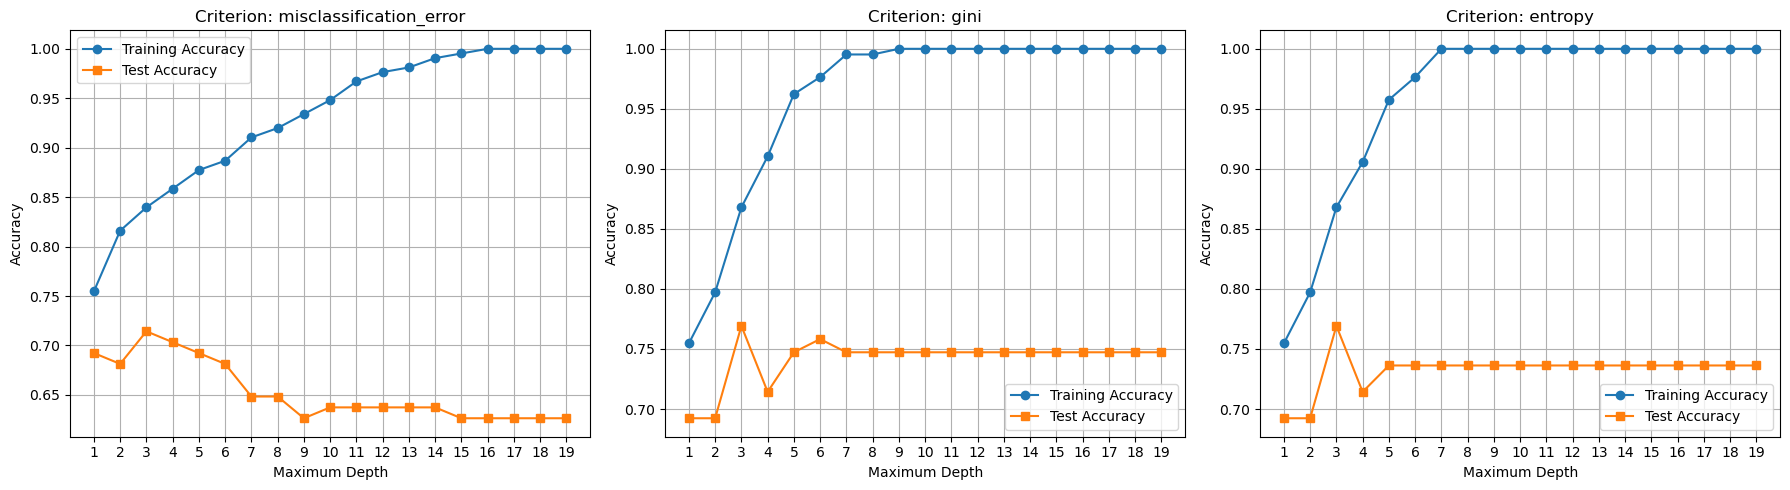

In [22]:
# Define criteria and depths
criteria = ['misclassification_error', 'gini', 'entropy']
max_depths = range(1, 20)

# Initialize a figure for plotting
plt.figure(figsize=(18, 5))

for idx, criterion in enumerate(criteria):
    train_accuracies = []
    test_accuracies = []

    for max_depth in max_depths:
        # Initialize the Decision Tree
        tree = DecisionTree(max_depth=max_depth, criterion=criterion)
        # Train the tree
        tree.build(X_train, y_train)
        # Predict on training data
        y_train_pred = tree.predict(X_train)
        # Predict on test data
        y_test_pred = tree.predict(X_test)
        # Calculate accuracies
        train_accuracy = np.mean(y_train_pred == y_train)
        test_accuracy = np.mean(y_test_pred == y_test)
        # Store accuracies
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    # Plotting
    plt.subplot(1, 3, idx + 1)
    plt.plot(max_depths, train_accuracies, marker='o', label='Training Accuracy')
    plt.plot(max_depths, test_accuracies, marker='s', label='Test Accuracy')
    plt.title(f'Criterion: {criterion}')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Accuracy')
    plt.xticks(max_depths)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()